# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.458611,False,-2.972597
1,-1.542767,False,-3.271322
2,1.472805,True,5.484167
3,-0.838632,False,-3.090955
4,-1.639997,True,2.729702
...,...,...,...
995,-1.943703,False,-4.289895
996,1.256829,True,7.052963
997,0.299659,True,6.813267
998,1.306189,True,6.999650


<AxesSubplot:xlabel='v0'>

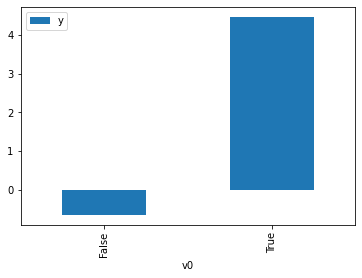

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

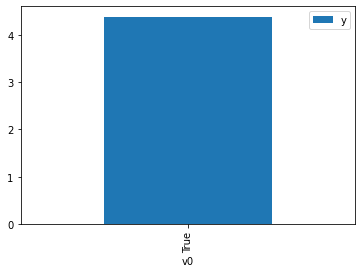

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.422722,False,-2.114200,0.919434,1.087626
1,-1.470616,False,-2.728382,0.925490,1.080508
2,-1.418728,False,-3.744910,0.918909,1.088247
3,-1.083979,False,0.298700,0.862420,1.159528
4,-0.508073,False,0.899215,0.693581,1.441792
...,...,...,...,...,...
995,-1.295315,False,-2.984849,0.901085,1.109774
996,-0.045899,False,-0.026670,0.499863,2.000547
997,1.153602,False,2.744859,0.106963,9.349003
998,-0.949116,False,-2.424427,0.831599,1.202503


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.138906,True,2.283783,0.126453,7.908060
1,0.541448,True,6.151780,0.738736,1.353664
2,0.394274,True,5.144971,0.685485,1.458821
3,1.641043,True,7.709163,0.951860,1.050575
4,-0.093108,True,6.130707,0.479274,2.086490
...,...,...,...,...,...
995,-0.278227,True,3.525537,0.398821,2.507389
996,0.657151,True,6.239023,0.776269,1.288214
997,-0.527790,True,3.105656,0.299058,3.343834
998,-1.131235,True,3.669502,0.127960,7.814965


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              7760.
Date:                Fri, 29 Jul 2022   Prob (F-statistic):                        0.00
Time:                        15:14:20   Log-Likelihood:                         -1397.8
No. Observations:                1000   AIC:                                      2800.
Df Residuals:                     998   BIC:                                      2809.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6290      0.029     56.562      0.000       1.572       1.686
x2             4.9986      0.050     99.433      0.000       4.900       5.097
==============================================================================
Omnibus:                        0.568   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.753   Jarque-Bera (JB):                0.443
Skew:                          -0.016   Prob(JB):                        0.801
Kurtosis:                       3.098   Cond. No.                         1.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""